# Sunny or Not?

----

Using 10 years of weather data in Basel, Switzerland, we attempt to predict if tomorrow will be **sunny or not**.

The model input consist of weather data such as temperature, humidity, precipitation, cloud cover, windspeed etc.  
The output will be a binary value of 1 or 0 indicating sunny or not.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import statistics

# 1. Obtaining 10 years of daily weather data from meteoblue

https://www.meteoblue.com/en/weather/

---

In [2]:
data = pd.read_csv("./basel_10years_weather.csv")

# 2. EDA

---

In [3]:
data.describe()

,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (high resolution) daily sum [sfc],Total Precipitation (low resolution) daily sum [sfc],...,Total Cloud Cover daily max [sfc],Total Cloud Cover daily min [sfc],High Cloud Cover daily max [high cld lay],High Cloud Cover daily min [high cld lay],Medium Cloud Cover daily max [mid cld lay],Medium Cloud Cover daily min [mid cld lay],Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd]
count,3652.000000,3652.000000,3652.000000,3652.0,3652.0,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,...,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,2013.500274,6.523549,15.727820,0.0,0.0,53.772716,71.698968,1016.841202,2.059091,2.626424,...,89.282585,8.798932,60.894852,0.766703,72.610077,2.026835,81.302848,4.202355,11.934934,2.226298
std,2.872293,3.449005,8.800529,0.0,0.0,12.875525,9.481184,8.028249,4.066025,5.137330,...,28.185679,23.597919,42.725502,3.971524,41.448185,10.998237,37.197206,17.758919,5.922558,2.467064
min,2009.000000,1.000000,1.000000,0.0,0.0,18.250000,37.120000,978.680000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.750000,0.000000
25%,2011.000000,4.000000,8.000000,0.0,0.0,43.637500,65.330000,1012.380000,0.000000,0.000000,...,100.000000,0.000000,17.000000,0.000000,33.000000,0.000000,100.000000,0.000000,7.660000,0.670000
50%,2013.500000,7.000000,16.000000,0.0,0.0,53.920000,72.310000,1016.960000,0.100000,0.200000,...,100.000000,0.000000,99.000000,0.000000,100.000000,0.000000,100.000000,0.000000,10.800000,1.430000
75%,2016.000000,10.000000,23.000000,0.0,0.0,63.730000,78.710000,1021.730000,2.400000,3.200000,...,100.000000,2.100000,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000,14.580000,2.910000
max,2018.000000,12.000000,31.000000,0.0,0.0,86.040000,95.540000,1046.970000,42.500000,66.500000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,49.700000,22.400000


## 2a. Identifying collinearity in the data

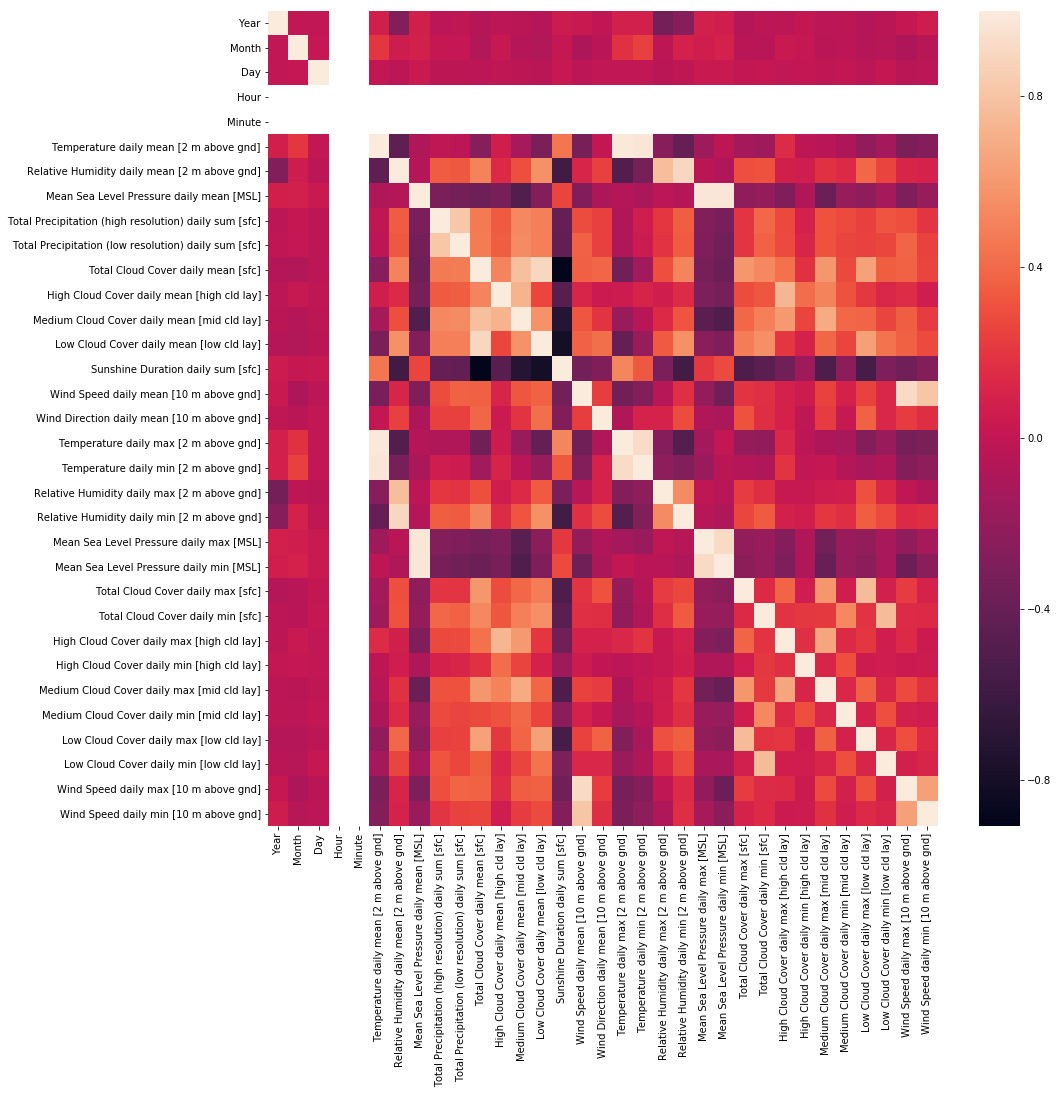

In [4]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax);

## 2b. Simplify features

In [5]:
# drop variables with multicollinearity
# simplify features

data = data.drop(['Temperature daily max [2 m above gnd]',
                  'Temperature daily min [2 m above gnd]',
                  'Relative Humidity daily max [2 m above gnd]',
                  'Relative Humidity daily min [2 m above gnd]',
                  'Mean Sea Level Pressure daily max [MSL]',
                  'Mean Sea Level Pressure daily min [MSL]',
                  'Wind Speed daily max [10 m above gnd]',
                  'Wind Speed daily min [10 m above gnd]',
                  'High Cloud Cover daily max [high cld lay]',
                  'High Cloud Cover daily min [high cld lay]',
                  'Medium Cloud Cover daily max [mid cld lay]',
                  'Medium Cloud Cover daily min [mid cld lay]',
                  'Low Cloud Cover daily max [low cld lay]',
                  'Low Cloud Cover daily min [low cld lay]'], axis=1)

## 2c. Define target as 'sunny' if Sunshine Duration is > 350 minutes.

---

In [6]:
data['Sunshine Duration daily sum [sfc]'].describe()

count    3652.000000
mean      369.276517
std       278.356924
min      -888.610000
25%       114.372500
50%       350.180000
75%       581.670000
max       962.280000
Name: Sunshine Duration daily sum [sfc], dtype: float64

In [7]:
# drop first row with negative sunshine
data = data[data['Sunshine Duration daily sum [sfc]'] >= 0]

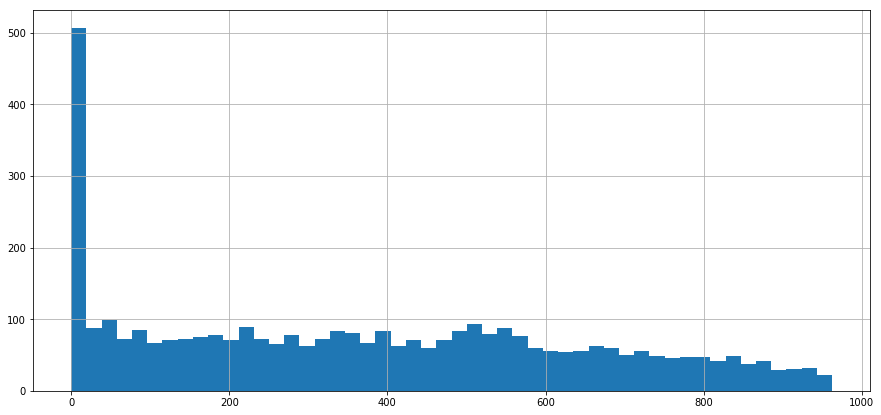

In [8]:
# plot distribution of sunshine duration
data['Sunshine Duration daily sum [sfc]'].hist(bins=50, figsize=(15,7));

In [9]:
# find median sunshine duration
statistics.median(data['Sunshine Duration daily sum [sfc]'])

350.25

In [10]:
# use median as threshold
# shift one day to obtain target

data['next_sunny'] = np.where(data['Sunshine Duration daily sum [sfc]']>=350, 1, 0)
data['next_sunny'] = data['next_sunny'].shift(-1);

# 3a. Feature Engineering

---

One-hot encode month as an indicator variable.

In [11]:
# create one hot encoding for months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(len(months)):
    month = months[i]
    idx = i+1
    data[month] = np.where(data['Month']==idx, 1, 0)   

# 3b. Train test split (80-20)

---

In [12]:
def train_test_split(df):
    train = df[df['Year']<=2016]
    train = train.dropna()
    X_train = train.drop(['Year', 'Month', 'Day', 'Hour', 'Minute',
                          'next_sunny'], axis=1)
    y_train = train['next_sunny']

    test = df[df['Year']>=2017]
    test = test.dropna()
    X_test = test.drop(['Year', 'Month', 'Day', 'Hour', 'Minute',
                        'next_sunny'], axis=1)
    y_test = test['next_sunny']
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = train_test_split(data)

# 4. Model Selection

## 4a. Baseline Model: 50% Sunny

---

Since our threshold is taken at the median of Sunshine Duration, 50% of days are sunny, 50% not.

## 4b. Model 1: Auto-regressive Logistic (1-day look back)

---

train_accuracy = 0.68, test_accuracy = 0.73, f1_score = 0.74

In [14]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [15]:
mod1_train_acc, mod1_test_acc = clf.score(X_train, y_train), clf.score(X_test, y_test)
mod1_f1_score = f1_score(y_test, y_pred)

print("Train Accuracy: {:2.2%}, Test Accuracy: {:2.2%}, F1-Score: {:2.2%}"
      .format(mod1_train_acc, mod1_test_acc, mod1_f1_score))

Train Accuracy: 67.65%, Test Accuracy: 72.70%, F1-Score: 74.26%


## 4c. Model 2: Auto-regressive Logistic (3-days look back)

---

train_accuracy = 0.70, test_accuracy = 0.71, f1_score = 0.74

In [16]:
# create features for 3 days look-back

exclusion = ['Year', 'Month', 'Day', 'Hour', 'Minute',
             'next_sunny', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 
             'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

data_auto = data.copy()

for column in data_auto.columns:
    if column not in exclusion:
        for i in range(1,3):
            new_col = column + '_t-' + str(i)
            data_auto[new_col] = data_auto[column].shift(i)

In [17]:
X_train, y_train, X_test, y_test = train_test_split(data_auto)

In [18]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [19]:
mod2_train_acc, mod2_test_acc = clf.score(X_train, y_train), clf.score(X_test, y_test)
mod2_f1_score = f1_score(y_test, y_pred)

print("Train Accuracy: {:2.2%}, Test Accuracy: {:2.2%}, F1-Score: {:2.2%}"
      .format(mod2_train_acc, mod2_test_acc, mod2_f1_score))

Train Accuracy: 69.54%, Test Accuracy: 71.60%, F1-Score: 74.22%


# 5. Imbalanced dataset

---

By adjusting the 'Sunshine Duration' threshold, we can make only 10% of the days be considered as 'sunny'.

In [20]:
data_imbalance = data.copy()
data_imbalance['next_sunny'] = np.where(data_imbalance['Sunshine Duration daily sum [sfc]']>=770, 1, 0)
data_imbalance['next_sunny'] = data_imbalance['next_sunny'].shift(-1)
data_imbalance['next_sunny'].describe()

count    3650.000000
mean        0.103288
std         0.304376
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: next_sunny, dtype: float64

## 5a. Model 3: Auto-regressive Logistic (1-day look back)

train_accuracy = 0.91, test_accuracy = 0.88, f1_score = 0.41

In [21]:
X_train, y_train, X_test, y_test = train_test_split(data_imbalance)

In [22]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [23]:
mod3_train_acc, mod3_test_acc = clf.score(X_train, y_train), clf.score(X_test, y_test)
mod3_f1_score = f1_score(y_test, y_pred)

print("Train Accuracy: {:2.2%}, Test Accuracy: {:2.2%}, F1-Score: {:2.2%}"
      .format(mod3_train_acc, mod3_test_acc, mod3_f1_score))

Train Accuracy: 90.69%, Test Accuracy: 88.20%, F1-Score: 41.10%


## 5b. Model 4: Auto-regressive Logistic (3-days look back)

---

train_accuracy = 0.91, test_accuracy = 0.88, f1_score = 0.44

In [24]:
data_imbalance_auto = data_imbalance.copy()
for column in data_imbalance_auto.columns:
    if column not in exclusion:
        for i in range(1,3):
            new_col = column + '_t-' + str(i)
            data_imbalance_auto[new_col] = data_imbalance_auto[column].shift(i)

In [25]:
X_train, y_train, X_test, y_test = train_test_split(data_imbalance_auto)

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [26]:
mod4_train_acc, mod4_test_acc = clf.score(X_train, y_train), clf.score(X_test, y_test)
mod4_f1_score = f1_score(y_test, y_pred)

print("Train Accuracy: {:2.2%}, Test Accuracy: {:2.2%}, F1-Score: {:2.2%}"
      .format(mod4_train_acc, mod4_test_acc, mod4_f1_score))

Train Accuracy: 90.68%, Test Accuracy: 88.34%, F1-Score: 44.44%


# 6. Oversampling

---

Use random oversampling to increase minority class to about 30%.

In [27]:
X_train, y_train, X_test, y_test = train_test_split(data_imbalance)

In [28]:
# random oversampling to increase minority class to about 30%
oversample_size = 800
new_X = []
new_y = []

y_pos = y_train[(y_train==1)]
pos_index = list(y_pos.index)
oversample_i = np.random.choice(len(pos_index), oversample_size)
for i in oversample_i:
    idx = pos_index[i]
    new_X.append(np.array(X_train.iloc[idx]))
    new_y.append(y_train[idx])

X_oversample = pd.DataFrame(np.array(new_X), columns=X_train.columns)
y_oversample = pd.Series(np.array(new_y))

X_train = X_train.append(X_oversample)
y_train = y_train.append(y_oversample)
X_train.shape, y_train.shape

((3721, 26), (3721,))

## 6a. Model 5: Auto-regressive Logistic with oversample (1-day look back) 

---

train_accuracy = 0.90, test_accuracy = 0.86, f1_score = 0.52

In [29]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [30]:
mod5_train_acc, mod5_test_acc = clf.score(X_train, y_train), clf.score(X_test, y_test)
mod5_f1_score = f1_score(y_test, y_pred)

print("Train Accuracy: {:2.2%}, Test Accuracy: {:2.2%}, F1-Score: {:2.2%}"
      .format(mod5_train_acc, mod5_test_acc, mod5_f1_score))

Train Accuracy: 90.03%, Test Accuracy: 85.60%, F1-Score: 52.05%


# 7. Models Comparison and Conclusion

In [45]:
performance = []
performance.append(('1-day Logit', mod1_train_acc, mod1_test_acc, mod1_f1_score))
performance.append(('3-day AutoRegLogit', mod2_train_acc, mod2_test_acc, mod2_f1_score))
performance.append(('1-day Logit (Imbalance)', mod3_train_acc, mod3_test_acc, mod3_f1_score))
performance.append(('1-day Logit (Imbalance+Oversample)', mod5_train_acc, mod5_test_acc, mod5_f1_score))

perform_df = pd.DataFrame(performance, columns=['Model', 'Train Acc', 'Test_Acc', 'F1-score'])
perform_df

,Model,Train Acc,Test_Acc,F1-score
0,1-day Logit,0.676481,0.727023,0.742561
1,3-day AutoRegLogit,0.695444,0.716049,0.742217
2,1-day Logit (Imbalance),0.906881,0.882030,0.410959
3,1-day Logit (Imbalance+Oversample),0.900296,0.855967,0.520548


## 7a. Key Learnings

### 1. 3-days auto-regressive logistic doesn't improve model significantly compared to 1-day logit.
### 2. Imbalance dataset increases train and test accuracy but lowers F1 score significantly.
### 3. Oversampling of minority dataset can improve F1-score in imbalance datasets.